In [ ]:
pip install pycaret

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_1samp, shapiro
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import recall_score, make_scorer, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG, display
# import shap

import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from pycaret.classification import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ml1_final_project/data_cardiovascular_risk.csv')
columns_to_convert = ['sex', 'education', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
df[columns_to_convert] = df[columns_to_convert].astype('object')
categorical_columns = df.select_dtypes(include='object').columns
numerical_columns = df.select_dtypes(include=['float', 'int']).columns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Remove rows where 'bpmeds' column is null
df = df.dropna(subset=['BPMeds'])

imputing_median1 = df[df['is_smoking'] == 'YES']['cigsPerDay'].median()
df['cigsPerDay'] = df['cigsPerDay'].fillna(imputing_median1)

df.drop('id', axis=1, inplace=True)
df.drop('education', axis=1, inplace=True)
df.drop(['is_smoking', 'prevalentStroke'], axis=1, inplace=True)

for var in ['totChol', 'BMI', 'heartRate']:
  imputer = IterativeImputer(random_state=0)
  df[[var]] = imputer.fit_transform(df[[var]])


# fit and transform the imputer on your data
imputer = IterativeImputer(random_state = 0)
imputer.fit(df[['glucose']])

df[['glucose']] = imputer.transform(df[['glucose']])


##### New Feature meanBP
# Create a new feature 'mean_BP' as the mean of 'sysBP' and 'diaBP'
df['mean_BP'] = (df['sysBP'] + df['diaBP']) / 2

# Drop the 'sysBP' and 'diaBP' columns
df.drop(['sysBP', 'diaBP'], axis=1, inplace=True)
###########

df = pd.get_dummies(df, drop_first=True)

X = df.drop(['TenYearCHD_1'], axis = 1)
y = df['TenYearCHD_1']

X_winsorized = X.copy()


# Apply winsorization to each column with the optimal limits
X_winsorized = X.copy()

X_winsorized['age'] = winsorize(X_winsorized['age'], limits=(0, 0))
X_winsorized['cigsPerDay'] = winsorize(X_winsorized['cigsPerDay'], limits=(0.7, 0.01))
X_winsorized['totChol'] = winsorize(X_winsorized['totChol'], limits=(0, 0))
# X_winsorized['sysBP'] = winsorize(X_winsorized['sysBP'], limits=(0, 0))
# X_winsorized['diaBP'] = winsorize(X_winsorized['diaBP'], limits=(0.8, 0))
X_winsorized['mean_BP'] = winsorize(X_winsorized['mean_BP'], limits=(0, 0))
X_winsorized['BMI'] = winsorize(X_winsorized['BMI'], limits=(0, 0))
X_winsorized['heartRate'] = winsorize(X_winsorized['heartRate'], limits=(0, 0))
X_winsorized['glucose'] = winsorize(X_winsorized['glucose'], limits=(0.7, 0.2))
X_winsorized['sex_M'] = winsorize(X_winsorized['sex_M'], limits=(0, 0))
X_winsorized['BPMeds_1.0'] = winsorize(X_winsorized['BPMeds_1.0'], limits=(0, 0))
X_winsorized['prevalentHyp_1'] = winsorize(X_winsorized['prevalentHyp_1'], limits=(0, 0.4))
X_winsorized['diabetes_1'] = winsorize(X_winsorized['diabetes_1'], limits=(0, 0))

# Split the winsorized data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_winsorized, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [ ]:
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


X_train_scaled = pd.DataFrame(X_train_s, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_s, columns=X_test.columns)

# Combine the dataframes vertically
X_combined = pd.concat([X_train_scaled, X_test_scaled], axis=0, ignore_index=True)
y_combined = pd.concat([y_train, y_test], axis=0, ignore_index=True)

df_new = pd.concat([X_combined, y_combined], axis=1, ignore_index=True)

In [ ]:
df_new = df_new.rename(columns=dict(zip(df_new.columns, X_winsorized.columns)))
df_new = df_new.rename(columns={11: "TenYearCHD"})

In [ ]:
df_new.head()

,age,cigsPerDay,totChol,BMI,heartRate,glucose,mean_BP,sex_M,BPMeds_1.0,prevalentHyp_1,diabetes_1,TenYearCHD
0,0.594595,0.000000,0.293718,0.086680,0.346939,0.0,0.294719,0.0,0.0,0.0,0.0,1
1,0.702703,0.000000,0.101868,0.000000,0.275510,0.0,0.420784,0.0,0.0,0.0,0.0,1
2,0.189189,0.178571,0.278438,0.276200,0.357143,0.0,0.306644,0.0,0.0,0.0,0.0,1
3,0.675676,0.178571,0.251273,0.281832,0.306122,0.0,0.335605,1.0,0.0,0.0,0.0,1
4,0.459459,0.000000,0.336163,0.230656,0.561224,0.0,0.412266,0.0,0.0,0.0,0.0,0


In [ ]:
from pycaret.classification import *

# Initialize the setup
clf = setup(data=df_new, target='TenYearCHD')

# Compare models
best_model = compare_models(sort='AUC')


,Description,Value
0,Session id,6247
1,Target,TenYearCHD
2,Target type,Binary
3,Original data shape,"(3346, 12)"
4,Transformed data shape,"(3346, 12)"
5,Transformed train set shape,"(2342, 12)"
6,Transformed test set shape,"(1004, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8514,0.7294,0.0480,0.5883,0.0870,0.0664,0.1312,0.8190
lda,Linear Discriminant Analysis,0.8429,0.7289,0.0736,0.3995,0.1233,0.0794,0.1156,0.0740
nb,Naive Bayes,0.8215,0.7168,0.2181,0.3481,0.2674,0.1725,0.1787,0.0640
rf,Random Forest Classifier,0.8403,0.7023,0.0482,0.2740,0.0791,0.0424,0.0598,0.6150
gbc,Gradient Boosting Classifier,0.8378,0.7001,0.0679,0.2879,0.1090,0.0608,0.0780,0.4520
ada,Ada Boost Classifier,0.8527,0.6998,0.1074,0.5475,0.1770,0.1363,0.1920,0.5580
et,Extra Trees Classifier,0.8463,0.6782,0.0680,0.4796,0.1169,0.0802,0.1299,0.7440
lightgbm,Light Gradient Boosting Machine,0.8352,0.6668,0.1073,0.3457,0.1570,0.0963,0.1169,0.2970
xgboost,Extreme Gradient Boosting,0.8267,0.6458,0.1274,0.3003,0.1746,0.0993,0.1106,0.4220
knn,K Neighbors Classifier,0.8348,0.6202,0.0965,0.3226,0.1462,0.0860,0.1050,0.1470


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
df_new.to_csv('Best_dataset_fp.csv')

In [ ]:
df_new.shape

(3346, 12)

In [ ]:
df_new.isnull().sum()

age               0
cigsPerDay        0
totChol           0
BMI               0
heartRate         0
glucose           0
mean_BP           0
sex_M             0
BPMeds_1.0        0
prevalentHyp_1    0
diabetes_1        0
TenYearCHD        0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_new.drop('TenYearCHD', axis=1), df_new['TenYearCHD'], test_size=0.2, random_state=42)

# Define the LightGBM classifier
lgbm = LGBMClassifier()

# Define the Repeated Stratified K-Fold cross-validator
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Initialize an empty list to store the AUC scores
auc_scores = []

# Iterate over the cross-validation splits
for train_index, val_index in rskf.split(X_train, y_train):
    # Split the data into train and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the LightGBM classifier on the current fold
    lgbm.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_val_pred = lgbm.predict_proba(X_val_fold)[:, 1]
    
    # Calculate and store the AUC score of the current fold
    fold_auc = roc_auc_score(y_val_fold, y_val_pred)
    auc_scores.append(fold_auc)

# Calculate the mean AUC score across all folds
mean_auc = sum(auc_scores) / len(auc_scores)

# Make predictions on the test set
y_test_pred = lgbm.predict_proba(X_test)[:, 1]

# Calculate the AUC score on the test set
test_auc = roc_auc_score(y_test, y_test_pred)

# Print the mean AUC score and test AUC score
print("Mean AUC:", mean_auc)
print("Test AUC:", test_auc)


Mean AUC: 0.6588951264378896
Test AUC: 0.6375883392226148


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:

# Make predictions on the test set
y_test_pred = lgbm.predict(X_test)

# Calculate the AUC score on the test set
test_auc = roc_auc_score(y_test, y_test_pred)

# Calculate the confusion matrix on the test set
confusion_mat = confusion_matrix(y_test, y_test_pred)

In [ ]:

# Calculate the confusion matrix on the test set
confusion_mat = confusion_matrix(y_test, y_test_pred)


[[549  17]
 [ 90  14]]


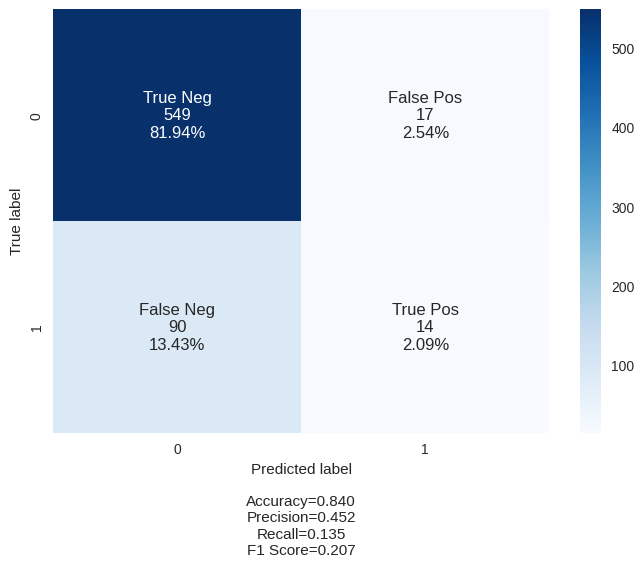

In [ ]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
print(cf_matrix)

labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["0", "1"]
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap="Blues")

In [ ]:
X = df_new.drop(['TenYearCHD'], axis = 1)
Y = df_new['TenYearCHD']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 8, stratify = Y, shuffle = True)
     

# Handling Imbalanced Dataset
smote = SMOTE(random_state = 8)
X_smote, Y_train_final = smote.fit_resample(X_train, Y_train)



# Scaling the train and test data according to train data
scaler = MinMaxScaler()
X_train_final = scaler.fit_transform(X_smote)
X_test_final = scaler.transform(X_test)

In [ ]:
Y_train_final.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


X_train_final_df = pd.DataFrame(X_train_final, columns=X_train.columns)
X_test_final_df = pd.DataFrame(X_test_final, columns=X_test.columns)

# Combine the dataframes vertically
X_combined = pd.concat([X_train_final_df, X_test_final_df], axis=0, ignore_index=True)
y_combined = pd.concat([Y_train_final, y_test], axis=0, ignore_index=True)

df_new_s = pd.concat([X_combined, y_combined], axis=1, ignore_index=True)

df_new_s = df_new_s.rename(columns=dict(zip(df_new_s.columns, X_winsorized.columns)))
df_new_s = df_new_s.rename(columns={11: "TenYearCHD"})

In [ ]:
df_new_s.shape

(5216, 12)

In [ ]:
df_new_s.isnull().sum()

age               0
cigsPerDay        0
totChol           0
BMI               0
heartRate         0
glucose           0
mean_BP           0
sex_M             0
BPMeds_1.0        0
prevalentHyp_1    0
diabetes_1        0
TenYearCHD        0
dtype: int64

In [ ]:
from pycaret.classification import *

# Initialize the setup
clf = setup(data=df_new_s, target='TenYearCHD')

# Compare models
best_model = compare_models(sort='AUC')


,Description,Value
0,Session id,1875
1,Target,TenYearCHD
2,Target type,Binary
3,Original data shape,"(5216, 12)"
4,Transformed data shape,"(5216, 12)"
5,Transformed train set shape,"(3651, 12)"
6,Transformed test set shape,"(1565, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8732,0.9358,0.8726,0.8533,0.8624,0.7448,0.7457,0.7130
lightgbm,Light Gradient Boosting Machine,0.8691,0.9269,0.8065,0.8960,0.8487,0.7339,0.7373,0.3320
xgboost,Extreme Gradient Boosting,0.8683,0.9261,0.8155,0.8869,0.8494,0.7327,0.7351,0.8050
rf,Random Forest Classifier,0.8447,0.9165,0.8251,0.8328,0.8286,0.6867,0.6871,1.1470
gbc,Gradient Boosting Classifier,0.7891,0.8648,0.7452,0.7822,0.7631,0.5733,0.5740,1.0020
knn,K Neighbors Classifier,0.7705,0.8531,0.8942,0.6926,0.7804,0.5481,0.5683,0.1040
ada,Ada Boost Classifier,0.7149,0.7817,0.6773,0.6912,0.6840,0.4243,0.4245,0.3680
dt,Decision Tree Classifier,0.7592,0.7583,0.7476,0.7309,0.7387,0.5156,0.5162,0.0870
lr,Logistic Regression,0.6691,0.7151,0.6058,0.6463,0.6247,0.3296,0.3307,0.5180
lda,Linear Discriminant Analysis,0.6683,0.7149,0.6112,0.6436,0.6263,0.3286,0.3296,0.0840


Processing:   0%|          | 0/65 [00:00<?, ?it/s]